In [46]:
import numpy as np
from re import sub
import tensorflow as tf
import seaborn as sns
import glob
import cv2
import os
import matplotlib.image as mpimg
import random
import matplotlib.colors as mcolors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation, Flatten, Dropout, Dense , MaxPool2D ,Input,GlobalAveragePooling2D,Average,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping,TensorBoard 
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
from tensorflow.keras import models
import matplotlib.pyplot as plt

from sklearn import preprocessing
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
print("Done importing packages!")

Done importing packages!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (255, 255)

data_dir = "/content/drive/MyDrive/test_dataset/potato_desease_detection/color"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 497 files belonging to 3 classes.
Using 398 files for training.
Found 497 files belonging to 3 classes.
Using 99 files for validation.


In [4]:
class_names = train_dataset.class_names
num_classes = len(class_names)

for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Early_blight
2.  Late_blight
3.  healthy


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 0


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [8]:
len(train_dataset)

13

In [9]:
METRICS = [
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
]

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input 

base_model = tf.keras.applications.InceptionV3(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

87910968/87910968 [==============================] - 1s 0us/step


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


In [12]:
base_model.trainable = True

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 2048)


In [14]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [15]:
inputs = tf.keras.Input(shape=(255, 255, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 255, 255, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 255, 255, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 255, 255, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [18]:
initial_epochs = 15

In [19]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
13/13 [==============================] - 338s 25s/step - loss: 0.3164 - accuracy: 0.8744 - precision: 0.9103 - recall: 0.8417 - val_loss: 0.2502 - val_accuracy: 0.9293 - val_precision: 0.9381 - val_recall: 0.9192
Epoch 2/15
13/13 [==============================] - 280s 22s/step - loss: 0.1642 - accuracy: 0.9623 - precision: 0.9670 - recall: 0.9573 - val_loss: 0.1018 - val_accuracy: 0.9697 - val_precision: 0.9697 - val_recall: 0.9697
Epoch 3/15
13/13 [==============================] - 281s 21s/step - loss: 0.0387 - accuracy: 0.9824 - precision: 0.9924 - recall: 0.9824 - val_loss: 0.1404 - val_accuracy: 0.9596 - val_precision: 0.9596 - val_recall: 0.9596
Epoch 4/15
13/13 [==============================] - 278s 21s/step - loss: 0.1307 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - val_loss: 0.1402 - val_accuracy: 0.9495 - val_precision: 0.9495 - val_recall: 0.9495
Epoch 5/15
13/13 [==============================] - 278s 21s/step - loss: 0.0576 - accuracy: 0.9799 - pr

In [ ]:
# training the model on the test set 
history = model.fit(test_dataset,
                    epochs=initial_epochs)

In [27]:

# save training weights in h5 file
model.save("model.h5")
print("\nModel weights saved!")


Model weights saved!


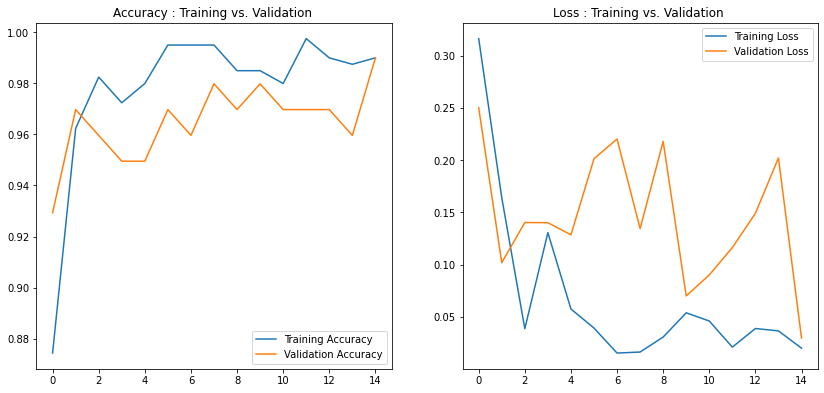

In [40]:
# performance evaluation
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
accuracy=history.history['accuracy']
plt.figure(figsize=(14, 14))
plt.subplot(2, 2, 1)
plt.plot(range(15), accuracy, label='Training Accuracy')
plt.plot(range(15), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training vs. Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), val_loss, label='Validation Loss')
plt.title('Loss : Training vs. Validation ')
plt.legend(loc='upper right')
plt.show()